In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
import numpy as np
import html
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('anime.csv', encoding='utf-8')
df['name'] = df['name'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

In [3]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [5]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [6]:
df.fillna({'rating':df['rating'].mean()},inplace=True)

In [7]:
df.isnull().sum()

anime_id     0
name         0
genre       62
type        25
episodes     0
rating       0
members      0
dtype: int64

In [8]:
df.fillna(df.median,inplace=True)

In [9]:
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

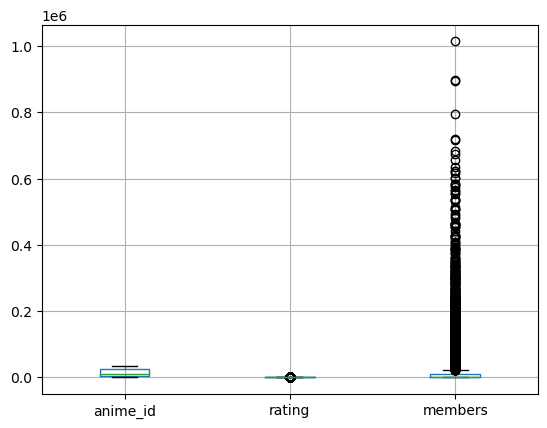

In [10]:
df.boxplot()
plt.show()

In [11]:
## Find inter quantile range to remove outliers
Q1=df['members'].quantile(.25)
Q3=df['members'].quantile(.75)
IQR=Q3-Q1
print(Q1,Q3,IQR)

225.0 9437.0 9212.0


In [12]:
lower_extreme=Q1-1.5*IQR
upper_extreme=Q3+1.5*IQR
print(lower_extreme ,upper_extreme)

-13593.0 23255.0


In [13]:
df=df[(df['members']<lower_extreme) | (df['members']>upper_extreme)]
df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
11530,746,Papa to Kiss in the Dark,"Comedy, Drama, Romance, Yaoi",OVA,2,6.47,28620
11566,8577,AkiSora Yume no Naka,"Ecchi, Romance, Seinen, Yuri",OVA,2,6.41,37519
12209,5391,Pico to Chico,"Hentai, Yaoi",OVA,1,5.19,29463
12213,4866,Pico x CoCo x Chico,"Hentai, Yaoi",OVA,1,5.16,27411


In [14]:
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [15]:
df.groupby('name')['rating'].mean().sort_values(ascending=False)

name
Kimi no Na wa                                             9.37
Fullmetal Alchemist Brotherhood                           9.26
SteinsGate                                                9.17
Gintama039                                                9.16
Haikyuu Karasuno Koukou VS Shiratorizawa Gakuen Koukou    9.15
                                                          ... 
Pico to Chico                                             5.19
Pico x CoCo x Chico                                       5.16
Boku no Pico                                              5.13
Pupa                                                      3.82
Hametsu no Mars                                           2.37
Name: rating, Length: 1886, dtype: float64

In [16]:
# Convert the 'type' column to strings
df['type'] = df['type'].astype(str)

C:\Users\CYRUS DADY\AppData\Local\Temp\ipykernel_5032\1361373359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].astype(str)


In [17]:
label_encoder = LabelEncoder()

In [18]:
# Apply the encoder to the column
df['type'] = label_encoder.fit_transform(df['type'])

C:\Users\CYRUS DADY\AppData\Local\Temp\ipykernel_5032\3482982742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = label_encoder.fit_transform(df['type'])


## Cosine_Similarity

### Item based

In [19]:
df1= df.pivot_table(index='name',columns='anime_id',values='rating')

In [20]:
df1.fillna(0,axis=1,inplace=True)

In [21]:
df1.head()

anime_id,1,5,6,7,15,16,18,19,20,21,...,33506,33524,33558,33674,33771,33985,34103,34134,34136,34240
name,,,,,,,,,,,,,,,,,,,,,
07Ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11eyes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11eyes Momoiro Genmutan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30sai no Hoken Taiiku,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3gatsu no Lion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
similarities=cosine_similarity(df1)
similarities

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [23]:
def recommended_movie(movie_name):
    if movie_name in df1.index:
        index= np.where(movie_name==df1.index)[0][0]
        similar_movie= sorted(list(enumerate(similarities[index])),key=lambda x: x[1],reverse=True)[1:6]
        print(f'Recommended_Anime of {movie_name}')
        print('-'*20)
        for movie in similar_movie:
            print(df1.index[movie[0]])
    else:
        print('Anime is not in the list')

In [24]:
recommended_movie('07Ghost')

Recommended_Anime of 07Ghost
--------------------
11eyes
11eyes Momoiro Genmutan
30sai no Hoken Taiiku
3gatsu no Lion
91 Days


In [25]:
similar_movie=sorted(list(enumerate(similarities[4])),key=lambda x: x[1],reverse=True)[1:6]

In [26]:
similar_movie

[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (5, 0.0)]

In [27]:
for movie in similar_movie:
    print(df1.index[movie[0]])

07Ghost
11eyes
11eyes Momoiro Genmutan
30sai no Hoken Taiiku
91 Days


### User based

In [28]:
df2= df.pivot_table(index='anime_id',columns='name',values='rating')

In [29]:
df2.fillna(0,axis=1,inplace=True)

In [30]:
df2

name,07Ghost,11eyes,11eyes Momoiro Genmutan,30sai no Hoken Taiiku,3gatsu no Lion,91 Days,A Kite,AChannel,AKB0048,Aa Megamisama,...,hackRoots,hackSign,hackTasogare no Udewa Densetsu,quotBungaku Shoujoquot Movie,sCRYed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
similarities= cosine_similarity(df2)

In [32]:
similarities
np.fill_diagonal(similarities,0)

In [33]:
df3=pd.DataFrame(similarities)
df3.index= df.anime_id.unique()
df3.columns=df.anime_id.unique()

In [34]:
df3.idxmax()

32281    32281
5114     32281
28977    32281
9253     32281
9969     32281
         ...  
746      32281
8577     32281
5391     32281
4866     32281
1639     32281
Length: 1900, dtype: int64

In [35]:
df[(df.anime_id==746  ) | (df.anime_id==32281)]

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",1,1,9.37,200630
11530,746,Papa to Kiss in the Dark,"Comedy, Drama, Romance, Yaoi",4,2,6.47,28620


In [36]:
df[(df.anime_id==8577  ) | (df.anime_id==5391 )]

,anime_id,name,genre,type,episodes,rating,members
11566,8577,AkiSora Yume no Naka,"Ecchi, Romance, Seinen, Yuri",4,2,6.41,37519
12209,5391,Pico to Chico,"Hentai, Yaoi",4,1,5.19,29463


In [37]:
target=df[['rating']]
features=df.drop(columns=['rating'])
features

,anime_id,name,genre,type,episodes,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",1,1,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",6,64,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",6,51,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",6,24,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",6,51,151266
...,...,...,...,...,...,...
11530,746,Papa to Kiss in the Dark,"Comedy, Drama, Romance, Yaoi",4,2,28620
11566,8577,AkiSora Yume no Naka,"Ecchi, Romance, Seinen, Yuri",4,2,37519
12209,5391,Pico to Chico,"Hentai, Yaoi",4,1,29463
12213,4866,Pico x CoCo x Chico,"Hentai, Yaoi",4,1,27411


In [38]:
xtrain,xtest,ytrain,ytest=train_test_split(features,target,train_size=.75,random_state=100)

## Interview Questions
#### 1. Can you explain the difference between user-based and item-based collaborative filtering?
User-based collaborative filtering finds users who have similar tastes to the target user and uses their preferences to make recommendations. It assumes that users who rated items similarly in the past will continue to have similar preferences. Item-based collaborative filtering, on the other hand, focuses on finding items that are similar to those the target user has already liked or rated highly. It assumes that if a user likes an item, they will likely enjoy items similar to it. Item-based filtering is often more scalable and stable, as items tend to have more consistent patterns than users.

#### 2. What is collaborative filtering, and how does it work?
Collaborative filtering is a recommendation technique that predicts user preferences based on user-item interactions. It operates on the assumption that users with similar preferences will continue to like similar items. This approach uses either user-based filtering, which identifies similar users, or item-based filtering, which finds items similar to those the user liked. Collaborative filtering involves calculating similarities, either between users or items, and then recommending items accordingly. It works well with rich user-item interaction data but struggles with new users or items due to limited historical data, a challenge known as the “cold start” problem.